*Resampling methods* involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model. Such an approach may allow us to obtain information that would not be available from fitting the model only once using the origin training sample.  

Here, we will discuss two of the most commonly used resampling methods, *cross-validation* and *bootstrap*. Cross-validation can be used to estimate the test error associated with a given statistical learning method in order to evaluate its performance, or to select the appropriate level of flexibility. The process of evaluating a model's performance is known as *model assessment*, whereas the process of selecting the proper level of flexibility for a model is known as *model selection*. The bootstrap is used in several contexts, most commonly to provide a measure of accuracy of a parameter estimate or of a given statistical learning method.

# Cross-Validation  
In the absence of a very large designated test set that can be used to directly estimate the test error rate, a number of techniques can be used to estimate this quantity using the available training data. In this section, we consider a class of methods that estimate the test error rate by *holding out* a subset of the training observations from the fitting process, then applying the statistical learning method to those held out observations.  

## The Validation Set Approach
The *validation set approach* is a very simple strategy for estimating the test error associated with fitting a particular statistical learning method on a set of observations. It involves randomly dividing the available set of observations into two parts, a *training set* and a *validation set* or *hold-out* set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate (typically assessed using MSE for quantitative responses), provides an estimate of the test error rate.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures as poly

%matplotlib inline

In [3]:
auto = pd.read_csv('../../data/Auto.csv', na_values='?')
auto.dropna(inplace=True)

X = auto['horsepower'].values.reshape(-1, 1)
y = auto['mpg'].values

[<matplotlib.text.Text at 0x1fdb2dd8>, <matplotlib.text.Text at 0x1fdac748>]

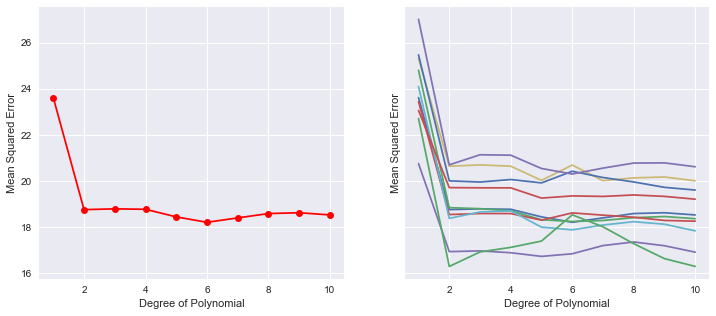

In [4]:
#Figure 5.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

deg = np.arange(1, 11)
lr = LinearRegression()

#left paneel
mse = []
for d in deg:
    p = poly(d)
    X_poly = p.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.5, random_state=0)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
ax1.plot(deg, mse, '-ro')
ax1.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error')

#right panel
#hard coding the random states because rs = 5 or 9 produce very bad plots (this is bad practice)
rs=[0, 1, 2, 3, 4, 6, 7, 8, 10, 12]
for i in range(10):
    mse = []
    for d in deg:
        p = poly(d)
        X_poly = p.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.5, random_state=rs[i])
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))
    ax2.plot(deg, mse, label=str(i))
ax2.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error')

In the left panel, we use a single 50-50 random split on the data to estimate the test error using the validation set MSE. In the right panel, we used 10 different 50-50 random splits of the data. Although there is no consensus among the curves as to which model results in the smallest validation set MSE, we can conclude that the linear fit is not adequate for this data.  

The validation set approach is simple and easy to implement, but has two potential drawbacks:  

 1. As shown in the right panel, the validatioin estimate of the test error rate can be highly variable, depending on precisely which obsrvations are included in the training set and which obsrvations are included in the validation set.  
 2. Since only a subset of the observations are used to fit the model, the validation set error rate may tend to *overestimate* the test error rate. This is because statistical methods tend to perform worse when trained on fewer observations.  

## Leave-One-Out Cross-Validation
*Leave-one-out cross-validation* (LOOCV) is closely related to the validation set approach, but it attempts to address that method's drawbacks.  

LOOCV involves splitting the observations into two parts, but instead of creating two subsets of comparable size, a single observation $(x_1, y_1)$ is used for the validation set, and the remaining observations $\{(x_2, y_2, ..., (x_n, y_n)\}$ make up the training set. The statistical method is fit on the $n-1$ training observations and the prediction $\widehat{y}_1$ is made for the excluded observation. Since $(x_1, y_1)$ was not used in the fitting process, $MSE_1=(y_1 - \widehat{y}_1)^2$ provides an approximately unbiased estimate for the test error. Although $MSE_1$ is unbiased for the test error, it's a poor estimate because it is highly variable.  

We can repeat this approach $n$ times to produce $n$ squared errors, $MSE_1, ..., MSE_n$. The LOOCV estimate for the test MSE is the average of these $n$ test error estimates:  

$$CV_{(n)}=\frac{1}{n}\sum_{i=1}^nMSE_i$$  

LOOCV has a couple of advantages over the validation set approach:  
 
 1. It has far less bias since we repeatedly fit the statistical learning method using training sets that contain $n-1$ observations. Consequently, it tends not to overestimate the test error rate as much as the validation approach.  
 2. Unlike the validation set approach, performing LOOCV multiple times will always yield the same results because there is no randomness to the training/validation set splits.

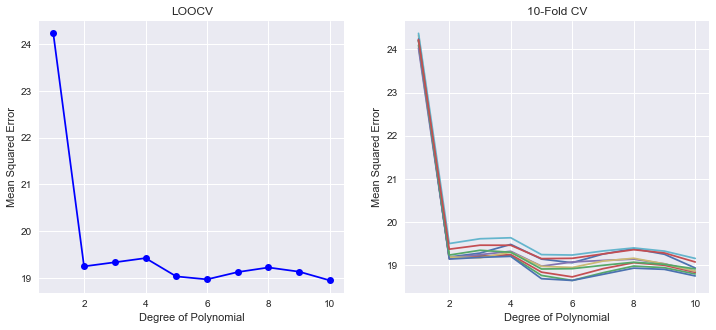

In [5]:
from sklearn.model_selection import LeaveOneOut
from sklearn.cross_validation import KFold

deg = np.arange(1, 11)
lr = LinearRegression()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#left panel
mse = []
loo = LeaveOneOut()
for d in deg:
    p = poly(d)
    X_poly = p.fit_transform(X)
    loo_mse = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        loo_mse.append((y_test - y_pred)**2)
    mse.append(np.mean(loo_mse))
ax1.plot(deg, mse, '-bo')
ax1.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error', title='LOOCV')
    
#right panel
for i in range(9):
    mse = []
    for d in deg:
        p = poly(d)
        X_poly = p.fit_transform(X)
        kf = KFold(len(X), n_folds=10, shuffle=True, random_state=i)
        kf_mse = []
        for train_index, test_index in kf:
            X_train, X_test = X_poly[train_index], X_poly[test_index]
            y_train, y_test = y[train_index], y[test_index]
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)
            kf_mse.append(((y_test - y_pred)**2).mean())
        mse.append(np.mean(kf_mse))
    ax2.plot(deg, mse)
ax2.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error', title='10-Fold CV');

In the left panel of the figure above we used LOOCV on the auto data set to obtain an estimate of the test set MSE that results from fitting a linear regression model to predict mpg using polynomial functions of horsepower.  

LOOCV has the potential to be expensive to implement, since the model has to be fit $n$ times. With least squares linear or polynomial regression, an amazing shortcut makes the cost of LOOCV the same as that of a single model fit. The following formula holds:  

$$CV_{(n)}=\frac{1}{n}\sum_{i=1}^n\biggl(\frac{y_i-\widehat{y}_i}{1-h_i}\biggr)^2$$  

where $h_i$ the leverage defined earlier 

$$h_i=\frac{1}{n}+\frac{(x_i-\bar{x})^2}{\sum_{i^{\prime}=1}^n(x_{i^{\prime}}-\bar{x})^2}$$

$CV_{(n)}$ is like the ordinary MSE except the $i$th residual is divided by $1-h_i$. The leverage lies between $1/n$ and 1 and reflects the amout that an observation influences its own fit. Hence, the residuals for high-leverage points are inflated in this formula by exactly the right amount for this equality to hold. The magic formula for $CV_{(n)}$ does not hold in general, in which case the model has to be refit $n$ times.

## $k$-Fold Cross-Validation
An alternative to LOOCV is *k-fold CV*. This approach involves randomly dividing the set of observations into $k$ groups, or *folds*, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining $k-1$ folds. The mean squared error is then computed on the observations in the held-out fold. This procedure is repeated $k$ times; each time, a different group of observations is treated as a validation set. This process results in $k$ estimates of the test error, $MSE_1, MSE_2, ..., MSE_k$. The $k$-fold CV estimate is computed by averaging these values  

$$CV_{(k)}=\frac{1}{k}\sum_{i=1}^kMSE_i$$  

LOOCV is a special case of $k$-fold CV in which $k=n$. Typically, one performs $k$-fold CV using $k=5$ or $k=10$.  

The right panel of the figure above displays nine different 10-fold CV estimates for the auto data set, each resulting from a different random split of the observations into ten folds. There is some variability in the CV estimates as a result of the variability in how the observations are divided into ten folds. But this variability is typically much lower than the variability in the test error estimates that result from the validation set approach.  

When we perform cross-validation, our goal might be to determine how well a given statistical learning method can be expected to perform on independent data. In this case, the actual estimate of the test MSE is of interest. In other times we are only interested in the location of the *minimum point in the estimated test MSE curve*. This is because we might be performing cross-validation on a number of statistical learning methods, or on a single method using different levels of flexibility, in order to identify the methot that results in the lowest test error. For this purpose the location of the minimum point in the estimated test MSE curve is important, but the actual value of the test MSE is no. 

## Bias-Variance Trade-Off for $k$-Fold Cross-Validation  
Computational issues aside, a less obvious but potentially more important advantage of $k$-fold CV is that it often gives more accurate estimates of the test error rate than does LOOCV, due to the bias-variance trade-off.  

The validation set approach can lead to overestimates of the test error rate since the training used to fit the statistical learning method contains only half of the observations. It's not hard to see that LOOCV will give approximately unbiased estimates of the test error, since each training set contains $n-1$ observations. And performing $k$-fold CV for, say $k=5$ or $k=10$ will lead to an intermediate level of bias. From the perspective of bias reduction, LOOCV is preferred to $k$-fold CV.  

However, since bias is not the only concern in an estimating procedure, we must also consider the procedure's variance. It turns out that LOOCV has a higher variance than $k$-fold CV with $k<n$. Why? For LOOCV, we are essentially averaging the outputs of $n$ fitted models, each of which is trained on an almost identical set of observations. Therefore, these outputs are highly (positively) correlated with each other. In contrast, in $k$-fold CV with $k<n$ we are averaging the output of $k$ fitted models that are somewhat less correlated with each other, since the overlap between the training sets in each model is smaller. Since the mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated, the test error estimates resulting from LOOCV tends to have higher variance than in $k$-fold CV.  

There is a bias-variance trade-off associated with the choice of $k$ in $k$-fold CV. Typically one performs $k$-fold CV using $k=5$ or $k=10$, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance

## Cross-Validation on Classification Problems  
Performing cross-validation for qualitative responses (regression) is similar to performing cross-validation for qualitative responses (classification), except that instead of using MSE to quantify test error, we instead use the number of misclassified observations. For instance, in the classification setting, the LOOCV error rate takes the form  

$$CV_{(n)}=\frac{1}{n}\sum_{i=1}^nErr_i$$  

where $Err_i = I(y_i \neq \widehat{y}_i)$. The $k$-fold CV error rate and validation set error rate are defined analogously.  

Because the Bayes decision boundary is usually not known for real data, we can use cross-validatioin in order to make the decision on which logistic regression polynomial order yields the lowest test error. Similarly, it can be used to identify the optimal value of $K$ in the KNN classifier because the training error rate cannot be used in this case. Though the cross-validation error curve will slightly underestimate the test error rate, it takes on a minimum very close to the best value for $K$.

# The Bootstrap
The *bootstrap* is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. As a simple example, the bootstrap can be used to estimate the standard error of the coefficients from a linear regression fit. The power of the bootstrap lies in the fact that it can be easily applied to a wide range of statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.  

As a toy example, suppose we wish to invest a fixed sum of money in two financial assets that yield returns of $X$ and $Y$, where $X$ and $Y$ are random quantities. We will invest a fraction $\alpha$ in $X$ and will invest the remaining $1-\alpha$ in $Y$. Since there is variability associated with the returns, we wish to choose $\alpha$ to minimize the total risk, or variance, of our investment. In other words, we want to minimize $Vary(\alpha X+(1-\alpha)Y$. One can show that the value that minimizes risk is  

$$\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2+\sigma_Y^2-2\sigma_{XY}}$$  

where $\sigma_X^2=Var(X)$, $\sigma_Y^2=Var(Y)$, and $\sigma_{XY}=Cov(X, Y)$.  

Since $\sigma_X^2$, $\sigma_Y^2$, and $\sigma_{XY}$, we can compute estimates for these quantities $\widehat{\sigma}_X^2$, $\widehat{\sigma}_Y^2$, and $\widehat{\sigma}_{XY}$, using a data set that contains past measurements for $X$ and $Y$. We can then estimate the value of $\alpha$ that minimizes the variance of our investment using  

$$\widehat{\alpha} = \frac{\widehat{\sigma}_Y^2 - \widehat{\sigma}_{XY}}{\widehat{\sigma}_X^2+\widehat{\sigma}_Y^2-2\widehat{\sigma}_{XY}}$$  

With a simulated data set, it is possible to estimate $\alpha$ by repeating the simulation of $X$ and $Y$, many times ($R$) and averaging all the $\widehat{\alpha}$'s obtained  

$$\bar{\alpha} = \frac{1}{n}\sum_{r=1}^R\widehat{\alpha}_r$$  

The standard deviation would be  

$$\sqrt{\frac{1}{R-1}\sum_{r=1}^R(\widehat{\alpha}_r-\bar{\alpha})^2}$$  

which would be the amount that we would expect $\widehat{\alpha}$ to deviate from $\alpha$ on average.  

In practice, we cannot generate new samples from the original population. However, the bootstrap approach allows us to use a computer to emulate the process of obtaining new sample sets, so that we can estimate the variability of $\widehat{\alpha}$ without generating additional samples. Rather than repeatedly obtaining independent data sets from the population, we instead obtain distinct data sets by repeatedly sampling observations *from the original data set*.  

We randomly select $n$ observations from the data set in order to produce a bootstrap data set, $Z^{*1}$. The sampling is done *with replacement*, which means that the same observation can occur more than once in the bootstrap data set. If an observation is contained in $Z^{*1}$, then both its $X$ and $Y$ values are included. We can use $Z^{*1}$ to produce a new bootstrap estimate for $\alpha$, which we call $\widehat{\alpha}^{*1}$. This is repeated $B$ times for some large value of $B$, in order to produce $B$ different bootstrap data sets, $Z^{*1}, Z^{*2}, ..., Z^{*B}$, and corresponding $\alpha$ estimates, $\widehat{\alpha}^{*1}, \widehat{\alpha}^{*2}, ..., \widehat{\alpha}^{*B}$. We can compute the standard error of these bootstrap estimates using the formula  

$$SE_B(\widehat{\alpha}) = \sqrt{\frac{1}{B-1}\sum_{i=1}^B\biggl(\widehat{\alpha}^{*r}-\frac{1}{B}\sum_{r^{\prime}=1}^B\widehat{\alpha}^{*r^{\prime}}\biggr)^2}$$  

which serves as an estimate of the standard error of $\widehat{\alpha}$ estimated from the original data set.